In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import openpyxl as op
from rapidfuzz import process, fuzz
import re
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.calibration import calibration_curve

In [3]:

# Bring in csv needed for the various variables needing to be created
school_stats = pd.read_csv(r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Combined after Cleaning\school_stats.csv", encoding="ISO-8859-1", header=0)
opp_school_stats = pd.read_csv(r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Combined after Cleaning\opponent_school_stats.csv", encoding="ISO-8859-1", header=0)
evan_miya_all_years_filtered = pd.read_csv(r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Second Cleaning and Filtered\evan_miya_all_years_filtered.csv", encoding="ISO-8859-1", header=0)
draft_data_filtered = pd.read_csv(r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Second Cleaning and Filtered\combined_draft_data_filtered.csv", encoding = 'ISO-8859-1', header=0)
tournament_result_filtered = pd.read_csv(r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Second Cleaning and Filtered\tournament_results_filtered.csv", encoding = 'ISO-8859-1', header=0)

# Bring in csv need for the various variable needing to be created / This code is to be used on work computer.
#school_stats = pd.read_csv(r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Combined after Cleaning\school_stats.csv", encoding="ISO-8859-1", header=0)
#opp_school_stats = pd.read_csv(r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Combined after Cleaning\opponent_school_stats.csv", encoding="ISO-8859-1", header=0)
#evan_miya_all_years_filtered = pd.read_csv(r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Second Cleaning and Filtered\evan_miya_all_years_filtered.csv", encoding="ISO-8859-1", header=0)
#draft_data_filtered = pd.read_csv(r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Second Cleaning and Filtered\combined_draft_data_filtered.csv", encoding = 'ISO-8859-1', header=0)
#tournament_result_filtered = pd.read_csv(r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Second Cleaning and Filtered\tournament_results_filtered.csv", encoding = 'ISO-8859-1', header=0)


   Year               Team  W-L%_basic  SRS_basic  SOS_basic  Tm_points  \
0  2014  Abilene Christian       0.355     -19.60      -4.12       2214   
1  2015  Abilene Christian       0.323     -17.20      -6.34       1976   
2  2016  Abilene Christian       0.419     -13.93      -7.53       2209   
3  2017  Abilene Christian       0.448     -11.86      -7.10       2009   
4  2018  Abilene Christian       0.500      -9.14      -6.82       2359   

   Opp_points    MP   FG   FGA  ...  SoS_NetRtg  SoS_ORtg  NCSOS_NetRtg  \
0        2228  1255  737  1664  ...         NaN       NaN           NaN   
1        2186  1240  695  1684  ...       -5.96     102.0         -1.93   
2        2272  1250  771  1704  ...       -7.76     101.4         -0.96   
3        2073  1180  721  1555  ...       -5.96     101.7          1.15   
4        2279  1290  870  1874  ...       -6.52     101.3         -3.16   

   Current_AP_Pre  Current_W-L%  CO_W-L%  CO_NCAA  CO_S16  CO_FF  CO_Chmp  
0             0.0     

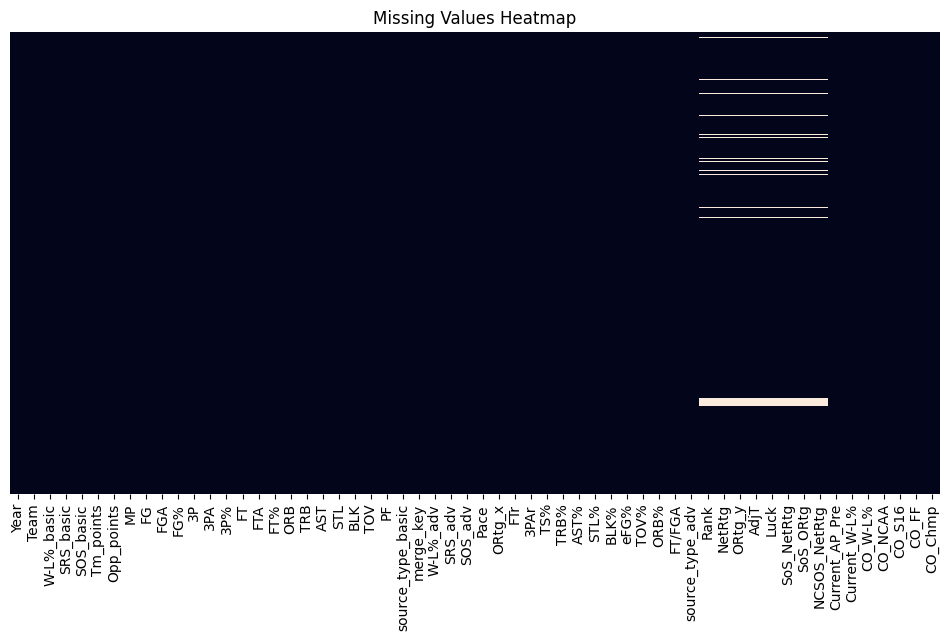

In [4]:
print(school_stats.head())
print()
print()
print('COLUMNS')
print(school_stats.columns)
print()
print()
print('SHAPE')
print(school_stats.shape)
print()
print()
print('INFO')
print(school_stats.info())
print()
print()
print('DESCRIBE')
print(school_stats.describe())
print()
print()
print('SUM NA')
print(school_stats.isna().sum().sort_values(ascending=False))
print()
print()
print('SUM DUPLICATED')
print(school_stats.duplicated().sum())
print()
print()
print('COLUMNS WITH NA')
nan_cols = school_stats.columns[school_stats.isna().any()]
print("Columns with NaN:", list(nan_cols))
print()
plt.figure(figsize=(12, 6))
sns.heatmap(school_stats.isna(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

Year                 0
Team                 0
W-L%_basic           0
SRS_basic            0
SOS_basic            0
Tm_points            0
Opp_points           0
MP                   0
FG                   0
FGA                  0
FG%                  0
3P                   0
3PA                  0
3P%                  0
FT                   0
FTA                  0
FT%                  0
ORB                  0
TRB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
source_type_basic    0
merge_key            0
W-L%_adv             0
SRS_adv              0
SOS_adv              0
Pace                 0
ORtg_x               0
FTr                  0
3PAr                 0
TS%                  0
TRB%                 0
AST%                 0
STL%                 0
BLK%                 0
eFG%                 0
TOV%                 0
ORB%                 0
FT/FGA               0
source_type_adv      0
Rank       

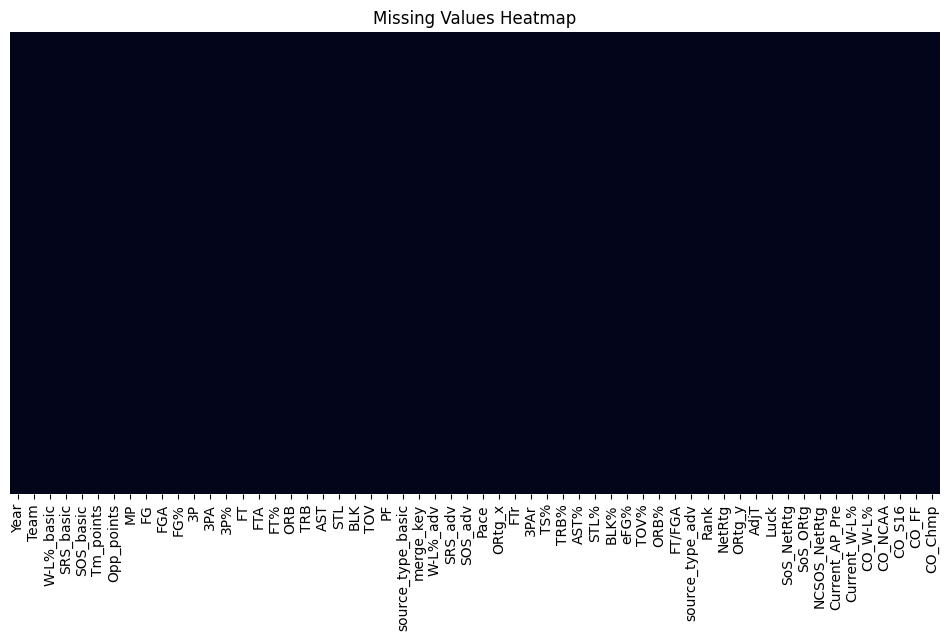

In [5]:
# Drop all rows with NA values
school_stats = school_stats.dropna()
print(school_stats.isna().sum().sort_values(ascending=False))
print()
plt.figure(figsize=(12, 6))
sns.heatmap(school_stats.isna(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

                Team  W-L%_basic  SRS_basic  SOS_basic     FG     FGA    FG%  \
0  Abilene Christian       0.355     -19.60      -4.12  759.0  1640.0  0.463   
1  Abilene Christian       0.323     -17.20      -6.34  748.0  1558.0  0.480   
2  Abilene Christian       0.419     -13.93      -7.53  792.0  1662.0  0.477   
3  Abilene Christian       0.448     -11.86      -7.10  708.0  1557.0  0.455   
4  Abilene Christian       0.500      -9.14      -6.82  770.0  1759.0  0.438   

      3P    3PA    3P%  ...  BLK%   eFG%  TOV%  ORB%  FT/FGA  source_type_adv  \
0  181.0  524.0  0.345  ...  12.0  0.518  17.8  30.2   0.323             NCAA   
1  183.0  509.0  0.360  ...  11.6  0.539  19.2  33.4   0.325             NCAA   
2  168.0  486.0  0.346  ...   8.6  0.527  18.2  26.9   0.313             NCAA   
3  210.0  581.0  0.361  ...   8.8  0.522  18.5  30.1   0.287             NCAA   
4  214.0  657.0  0.326  ...   7.5  0.499  19.5  28.5   0.298             NCAA   

    DRtg   Luck  SoS_DRtg  NCSOS

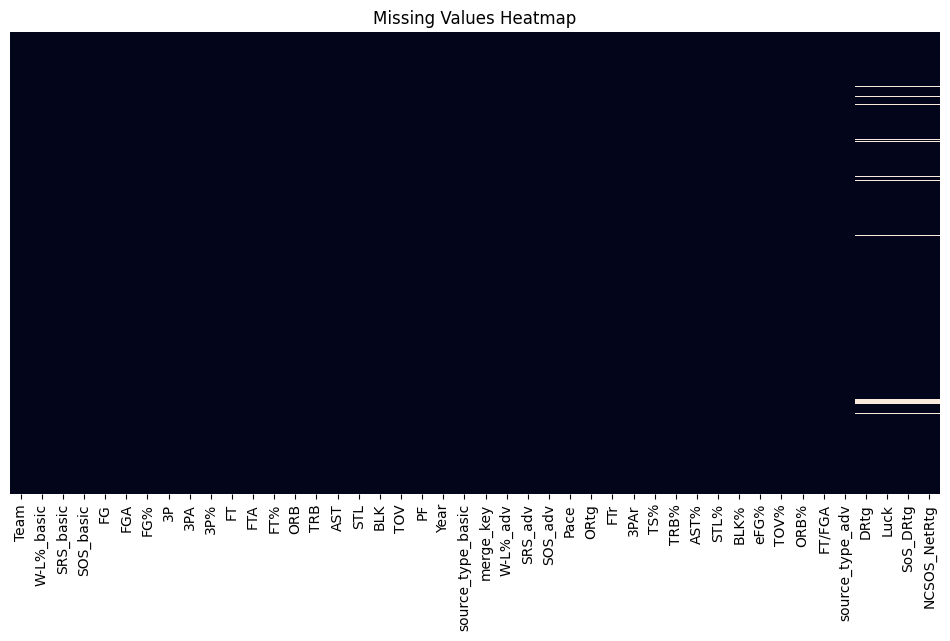

In [6]:
print(opp_school_stats.head())
print()
print()
print('COLUMNS')
print(opp_school_stats.columns)
print()
print()
print('SHAPE')
print(opp_school_stats.shape)
print()
print()
print('INFO')
print(opp_school_stats.info())
print()
print()
print('DESCRIBE')
print(opp_school_stats.describe())
print()
print()
print('SUM NA')
print(opp_school_stats.isna().sum().sort_values(ascending=False))
print()
print()
print('SUM DUPLICATED')
print(opp_school_stats.duplicated().sum())
print()
print()
print('COLUMNS WITH NA')
nan_cols = opp_school_stats.columns[opp_school_stats.isna().any()]
print("Columns with NaN:", list(nan_cols))
print()
plt.figure(figsize=(12, 6))
sns.heatmap(opp_school_stats.isna(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

Team                 0
W-L%_basic           0
SRS_basic            0
SOS_basic            0
FG                   0
FGA                  0
FG%                  0
3P                   0
3PA                  0
3P%                  0
FT                   0
FTA                  0
FT%                  0
ORB                  0
TRB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
Year                 0
source_type_basic    0
merge_key            0
W-L%_adv             0
SRS_adv              0
SOS_adv              0
Pace                 0
ORtg                 0
FTr                  0
3PAr                 0
TS%                  0
TRB%                 0
AST%                 0
STL%                 0
BLK%                 0
eFG%                 0
TOV%                 0
ORB%                 0
FT/FGA               0
source_type_adv      0
DRtg                 0
Luck                 0
SoS_DRtg             0
NCSOS_NetRt

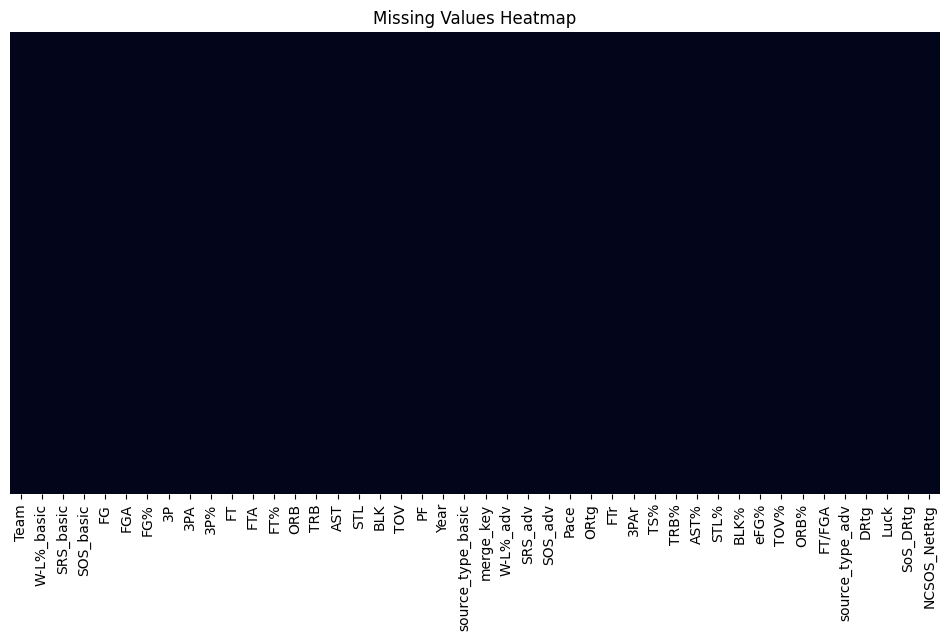

In [7]:
# Drop all rows with NA values
opp_school_stats = opp_school_stats.dropna()
print(opp_school_stats.isna().sum().sort_values(ascending=False))
print()
plt.figure(figsize=(12, 6))
sns.heatmap(opp_school_stats.isna(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [8]:
#merge the way I used to as a loop through years and teams
all_combined_stats_df = []
seasons = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024, 2025]
ncaa_tournament_teams = [
    "Air Force", "Akron", "Alabama", "Alabama A&M", "Alabama State", "Albany", "Alcorn State",
    "American", "Appalachian State", "Arizona", "Arizona State", "Arkansas", "Arkansas State",
    "Arkansas-Pine Bluff", "Army", "Auburn", "Austin Peay", "Ball State", "Baylor", "Belmont",
    "Bethune-Cookman", "Binghamton", "Boise State", "Boston College", "Boston University",
    "Bowling Green", "Bradley", "BYU", "Brown", "Bryant", "Bucknell", "Buffalo", "Butler",
    "Cal Poly", "Cal State Bakersfield", "Cal State Fullerton", "Cal State Northridge", "California",
    "Campbell", "Canisius", "Central Arkansas", "Central Connecticut State", "Central Michigan",
    "Charleston Southern", "Charlotte", "Chattanooga", "Chicago State", "Cincinnati", "Clemson",
    "Cleveland State", "Coastal Carolina", "Colgate", "College of Charleston", "Colorado",
    "Colorado State", "Columbia", "Connecticut", "Coppin State", "Cornell", "Creighton", "Dartmouth",
    "Davidson", "Dayton", "Delaware", "Delaware State", "Denver", "DePaul", "Detroit Mercy", "Drake",
    "Drexel", "Duke", "Duquesne", "East Carolina", "East Tennessee State", "Eastern Illinois",
    "Eastern Kentucky", "Eastern Michigan", "Eastern Washington", "Elon", "Evansville", "Fairfield",
    "FDU", "Florida", "Florida A&M", "Florida Atlantic", "Florida Gulf Coast", "Florida International",
    "Florida State", "Fordham", "Fresno State", "Furman", "Gardner-Webb", "George Mason",
    "George Washington", "Georgetown", "Georgia", "Georgia Southern", "Georgia State", "Georgia Tech",
    "Gonzaga", "Grambling", "Green Bay", "Hampton", "Hartford", "Harvard", "Hawaii", "High Point",
    "Hofstra", "Holy Cross", "Houston", "Houston Christian", "Howard", "Idaho", "Idaho State",
    "Illinois", "Illinois State", "Illinois-Chicago", "Indiana", "Indiana State", "Iona", "Iowa",
    "Iowa State", "IU Indy", "Jackson State", "Jacksonville", "Jacksonville State", "James Madison",
    "Kansas", "Kansas City", "Kansas State", "Kennesaw State", "Kent State", "Kentucky", "La Salle",
    "Lafayette", "Lamar", "Lehigh", "Liberty", "Lipscomb", "Little Rock", "Long Beach State",
    "Long Island University", "Longwood", "Louisiana", "Louisiana State", "Louisiana Tech",
    "Louisiana-Monroe", "Louisville", "Loyola (IL)", "Loyola (MD)", "Loyola Marymount", "Maine",
    "Manhattan", "Marist", "Marquette", "Marshall", "Maryland", "Maryland-Baltimore County",
    "Maryland-Eastern Shore", "Massachusetts", "McNeese State", "Memphis", "Mercer", "Miami (FL)",
    "Miami (OH)", "Michigan", "Michigan State", "Middle Tennessee", "Milwaukee", "Minnesota",
    "Mississippi", "Mississippi State", "Mississippi Valley State", "Missouri", "Missouri State",
    "Monmouth", "Montana", "Montana State", "Morehead State", "Morgan State", "Mount St. Mary's",
    "Murray State", "Navy", "NC State", "Nebraska", "Nevada", "UNLV", "New Hampshire", "New Mexico",
    "New Mexico State", "Niagara", "Nicholls State", "NJIT", "Norfolk State",
    "North Carolina A&T", "North Carolina Central", "North Dakota", "North Dakota State",
    "North Florida", "North Texas", "Northeastern", "Northern Arizona", "Northern Colorado",
    "Northern Illinois", "Northern Iowa", "Northwestern", "Northwestern State", "Notre Dame", "Oakland",
    "Ohio", "Ohio State", "Oklahoma", "Oklahoma State", "Old Dominion", "Oral Roberts", "Oregon",
    "Oregon State", "Pacific", "Penn State", "Pennsylvania", "Pepperdine", "Pittsburgh", "Portland",
    "Portland State", "Prairie View", "Presbyterian", "Princeton", "Providence", "Purdue",
    "Purdue Fort Wayne", "Quinnipiac", "Radford", "Rhode Island", "Rice", "Richmond", "Rider",
    "Robert Morris", "Rutgers", "Sacramento State", "Sacred Heart", "Saint Francis (PA)",
    "Saint Joseph's", "Saint Louis", "Saint Mary's", "Saint Peter's", "Sam Houston", "Samford",
    "San Diego", "San Diego State", "San Francisco", "San Jose State", "Santa Clara", "Savannah State",
    "Seattle", "Seton Hall", "Siena", "South Alabama", "South Carolina", "South Carolina State",
    "South Carolina Upstate", "South Dakota", "South Dakota State", "South Florida", "Southeast Missouri State",
    "Southeastern Louisiana", "Southern", "Southern California", "Southern Illinois", "SIU Edwardsville",
    "SMU", "Southern Mississippi", "Southern Utah", "St. Bonaventure", "St. Francis (NY)", "St. John's",
    "Stanford", "Stephen F. Austin", "Stetson", "Stony Brook", "Syracuse", "TCU", "Temple", "Tennessee",
    "Tennessee State", "Tennessee Tech", "Tennessee-Martin", "Texas", "Texas A&M",
    "Texas A&M-Corpus Christi", "Texas Southern", "Texas State", "Texas Tech", "Texas-Rio Grande Valley",
    "The Citadel", "Toledo", "Towson", "Troy", "Tulane", "Tulsa", "UAB", "UC Davis", "UC Irvine",
    "UC Riverside", "UC Santa Barbara", "UCF", "UCLA", "UNC Asheville", "UNC Greensboro",
    "UNC Wilmington", "UT Arlington", "Utah", "Utah State", "Utah Valley", "UTEP", "UTSA", "Valparaiso",
    "Vanderbilt", "Vermont", "Villanova", "Virginia", "VCU", "VMI", "Virginia Tech", "Wagner",
    "Wake Forest", "Washington", "Washington State", "Weber State", "West Virginia",
    "Western Carolina", "Western Illinois", "Western Kentucky", "Western Michigan", "Wichita State",
    "William & Mary", "Winthrop", "Wisconsin", "Wofford", "Wright State", "Wyoming", "Xavier",
    "Yale", "Youngstown State", 'Abilene Christian', 'Fairleigh Dickinson', 'Grand Canyon', 'Nebraska Omaha', 
    'Alabama-Birmingham', 'Bellarmine', 'Cal Baptist', 'Utah Tech', 'Queens', 'Saint Thomas (Minn.)', 'UMass Lowell', 
    'IUPUI', 'Incarnate Word', 'Merrimack', 'Le Moyne', 'New Orleans', 'Arkansas-Little Rock', 'California Baptist', 
    'Central Florida', 'Lindenwood', 'Louisiana-Lafayette', 'Mercyhurst', 'Missouri-Kansas City', 'North Alabama', 'Northern Kentucky',
    'Saint Thomas', 'Southern Indiana', 'Stonehill', 'Tarleton State', 'Texas A&M-Commerce', 'West Georgia', 'Tarleton St.', 'Houston Baptist',
    'Texas Pan American', 'International', 'Not A College', 'Shawnee State','Arkansas Little Rock', 'Southeast Missouri', 'St. Francis NY', 
    'Texas A&M Commerce', 'North Carolina'  
]

# Create function that will loop through each year and each team combining the statistics.  This mergekey did not work well, so this is a different method.
for season in seasons:
    for teams in ncaa_tournament_teams:
        # Filter both datasets for current team and season
        school_row = school_stats[(school_stats["Year"] == season) & (school_stats['Team'] == teams)]
        opp_row = opp_school_stats[(opp_school_stats["Year"] == season) & (opp_school_stats['Team'] == teams)]
        # Only merge if both sides exist
        if not school_row.empty and not opp_row.empty:
            # Reset index for concat
            merged_row = pd.concat([school_row.reset_index(drop=True), opp_row.reset_index(drop=True)], axis=1)
            all_combined_stats_df.append(merged_row)
# Concatenate all results into a single DataFrame
final_combined_df = pd.concat(all_combined_stats_df, ignore_index=True)

In [9]:
final_combined_df

,Year,Team,W-L%_basic,SRS_basic,SOS_basic,Tm_points,Opp_points,MP,FG,FGA,...,BLK%,eFG%,TOV%,ORB%,FT/FGA,source_type_adv,DRtg,Luck,SoS_DRtg,NCSOS_NetRtg
0,2012,Air Force,0.448,-0.45,2.14,1786,1798,1170,616,1383,...,9.2,0.477,19.0,33.7,0.262,NCAA,102.2,-0.017,101.2,-11.06
1,2012,Air Force,0.448,-0.45,2.14,1786,1798,1170,616,1383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012,Akron,0.647,6.33,0.72,2456,2241,1370,868,1879,...,8.8,0.465,17.6,36.4,0.234,NCAA,97.7,-0.021,101.8,3.86
3,2012,Alabama,0.636,13.76,7.18,2135,1918,1330,778,1722,...,9.4,0.437,17.9,34.3,0.247,NCAA,89.5,-0.067,100.3,3.98
4,2012,Alabama A&M,0.250,-19.33,-10.79,1764,1964,1130,629,1538,...,10.8,0.491,17.8,37.4,0.333,NCAA,111.4,-0.063,104.8,9.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793,2025,Northern Kentucky,0.515,-4.79,-3.14,2371,2377,1340,852,1946,...,8.9,0.521,17.5,32.3,0.216,NCAA,108.2,0.041,108.8,3.36
4794,2025,Southern Indiana,0.333,-13.86,-8.40,2144,2204,1215,766,1791,...,8.1,0.505,14.6,30.8,0.229,NCAA,114.9,-0.027,109.7,-2.30
4795,2025,Stonehill,0.469,-13.12,-9.55,2198,2242,1280,759,1748,...,12.4,0.503,14.6,28.5,0.237,NCAA,115.2,0.031,110.1,-2.97
4796,2025,West Georgia,0.194,-15.57,-4.50,2140,2426,1241,803,1848,...,7.3,0.555,14.9,29.2,0.259,NCAA,115.5,0.012,109.3,1.94


   Year         Team  W-L%_basic  SRS_basic  SOS_basic  Tm_points  Opp_points  \
0  2012    Air Force       0.448      -0.45       2.14       1786        1798   
1  2012    Air Force       0.448      -0.45       2.14       1786        1798   
2  2012        Akron       0.647       6.33       0.72       2456        2241   
3  2012      Alabama       0.636      13.76       7.18       2135        1918   
4  2012  Alabama A&M       0.250     -19.33     -10.79       1764        1964   

     MP   FG   FGA  ...  BLK%   eFG%  TOV%  ORB%  FT/FGA  source_type_adv  \
0  1170  616  1383  ...   9.2  0.477  19.0  33.7   0.262             NCAA   
1  1170  616  1383  ...   NaN    NaN   NaN   NaN     NaN              NaN   
2  1370  868  1879  ...   8.8  0.465  17.6  36.4   0.234             NCAA   
3  1330  778  1722  ...   9.4  0.437  17.9  34.3   0.247             NCAA   
4  1130  629  1538  ...  10.8  0.491  17.8  37.4   0.333             NCAA   

    DRtg   Luck  SoS_DRtg  NCSOS_NetRtg  
0  102.2

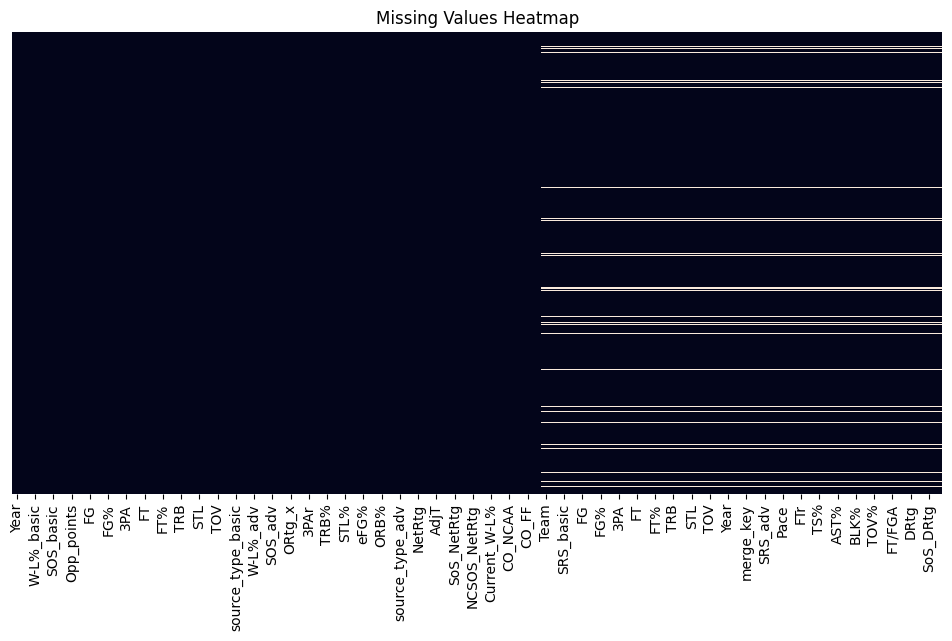

In [10]:
print(final_combined_df.head())
print()
print()
print('COLUMNS')
print(final_combined_df.columns)
print()
print()
print('SHAPE')
print(final_combined_df.shape)
print()
print()
print('INFO')
print(final_combined_df.info())
print()
print()
print('DESCRIBE')
print(final_combined_df.describe())
print()
print()
print('SUM NA')
print(final_combined_df.isna().sum().sort_values(ascending=False))
print()
print()
print('SUM DUPLICATED')
print(final_combined_df.duplicated().sum())
print()
print()
print('COLUMNS WITH NA')
nan_cols = final_combined_df.columns[final_combined_df.isna().any()]
print("Columns with NaN:", list(nan_cols))
print()
plt.figure(figsize=(12, 6))
sns.heatmap(final_combined_df.isna(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [11]:
# checking for duplicate columns 
duplicated_columns = final_combined_df.columns[final_combined_df.columns.duplicated()]
print(f"Number of duplicated columns: {len(duplicated_columns)}")
print("Duplicated columns:", duplicated_columns.tolist())

# Drop Duplicate columns
final_combined_df = final_combined_df.loc[:, ~final_combined_df.columns.duplicated()]


Number of duplicated columns: 41
Duplicated columns: ['Team', 'W-L%_basic', 'SRS_basic', 'SOS_basic', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'Year', 'source_type_basic', 'merge_key', 'W-L%_adv', 'SRS_adv', 'SOS_adv', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'source_type_adv', 'Luck', 'NCSOS_NetRtg']


In [12]:
# Create an actual copy before modifying
final_combined_df = final_combined_df.copy()

# Now safely drop the columns
final_combined_df.drop(columns=['Tm_points', 'Opp_points', 'MP', 'source_type_basic', 'W-L%_adv', 'SRS_adv', 'SOS_adv', 'source_type_adv'], inplace=True)


In [14]:
output_path = r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Combined after Cleaning\final_combined_df.csv"

#Work Path
#output_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Variable Creation Sheet Work addresses\final_combined_df.csv"
final_combined_df.to_csv(output_path, index=False)

In [16]:
# Drop unneeded columns
tournament_result_filtered.drop(columns=['BY YEAR NO'], inplace=True)

# Fix header alignment with tournament results
tournament_result_filtered = tournament_result_filtered.rename(columns={"TEAM": "Team", "YEAR": "Year", 'SEED' : 'Seed', 'CURRENT ROUND' : 'Current Round',
                                                                       'SCORE' : 'Score', 'TEAM NO' : 'Team No'})

# Ensure numeric types
tournament_result_filtered["Score"] = pd.to_numeric(tournament_result_filtered["Score"], errors="coerce")
tournament_result_filtered["Opponenet Score"] = pd.to_numeric(tournament_result_filtered["Opponenet Score"], errors="coerce")

# Champion logic
tournament_result_filtered["Champion"] = (
    (tournament_result_filtered["Current Round"] == 2) & (tournament_result_filtered["Score"] > tournament_result_filtered["Opponenet Score"])).astype(int)


KeyError: "['BY YEAR NO'] not found in axis"

In [ ]:
tournament_result_filtered

In [ ]:
# Create Merge Key in tournament_result_filtered
tournament_result_filtered["merge_key"] = tournament_result_filtered["Team"] + "_" + tournament_result_filtered["Year"].astype(str)

In [18]:
output_path = r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Combined after Cleaning\tournament_result_filtered.csv"

# Work Path
#output_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Variable Creation Sheet Work addresses\tournament_result_filtered.csv"

tournament_result_filtered.to_csv(output_path, index=False)

In [19]:
champions = tournament_result_filtered[tournament_result_filtered["Champion"] == 1][["Year", "Team"]]
print(champions.sort_values("Year", ascending=False))

      Year            Team
132   2025         Florida
258   2024     Connecticut
385   2023     Connecticut
511   2022          Kansas
635   2021          Baylor
761   2019       Virginia 
887   2018       Villanova
1013  2017  North Carolina
1138  2016       Villanova
1265  2015            Duke
1390  2014     Connecticut
1516  2013      Louisville
1642  2012        Kentucky


In [55]:
# Create initial df with only needed starting columns
champion_predictor_df = tournament_result_filtered.drop(columns=['Team No', 'Opponent', 'Opponenet Score', 'Result'])
# Create list of just tournament teams
tournament_teams = tournament_result_filtered["Team"].dropna().astype(str).str.strip()
# Sort out duplicate team names
tournament_teams = sorted(tournament_teams.unique())
print(f" Total unique teams: {len(tournament_teams)}")
print(tournament_teams[:25])  # Show first 25 as a sanity check
print(champion_predictor_df.head())
print(champion_predictor_df.columns)

 Total unique teams: 229
['Abilene Christian', 'Akron', 'Alabama', 'Alabama St.', 'Albany', 'American', 'Arizona', 'Arizona St.', 'Arkansas', 'Auburn', 'Austin Peay', 'BYU', 'Baylor', 'Belmont', 'Boise St.', 'Bradley', 'Bryant', 'Bucknell', 'Buffalo', 'Butler', 'Cal Poly', 'Cal St. Bakersfield', 'Cal St. Fullerton', 'California', 'Chattanooga']
   Year              Team  Seed  Current Round  Score  Opponent Rank  Champion
0  2025       Alabama St.    16             68     68             16         0
1  2025     Saint Francis    16             68     70             16         0
2  2025    North Carolina    11             68     95             11         0
3  2025     San Diego St.    11             68     68             11         0
4  2025  Mount St. Mary's    16             68     83             16         0
Index(['Year', 'Team', 'Seed', 'Current Round', 'Score', 'Opponent Rank',
       'Champion'],
      dtype='object')


In [22]:
champion_predictor_df = []

for season in seasons:
    for team in ncaa_tournament_teams:
        tournament_slice = tournament_result_filtered[(tournament_result_filtered["Year"] == season) & (tournament_result_filtered["Team"] == team)]

        stats_slice = final_combined_df[(final_combined_df["Year"] == season) & (final_combined_df["Team"] == team)]

        if not tournament_slice.empty and not stats_slice.empty:
            # Repeat stats row to match tournament_slice length
            stats_repeated = pd.concat([stats_slice]*len(tournament_slice), ignore_index=True)
            merged_row = pd.concat([tournament_slice.reset_index(drop=True), stats_repeated.reset_index(drop=True)], axis=1)
            champion_predictor_df.append(merged_row)

      Year  Team No         Team  Seed  Current Round  Score  \
0   2012.0    331.0      Alabama   9.0           64.0   57.0   
1   2012.0    330.0       Baylor   3.0           64.0   68.0   
2   2012.0    330.0       Baylor   3.0           32.0   80.0   
3   2012.0    330.0       Baylor   3.0           16.0   75.0   
4   2012.0    330.0       Baylor   3.0            8.0   70.0   
5   2012.0    329.0      Belmont  14.0           64.0   59.0   
6   2012.0    328.0          BYU  14.0           64.0   68.0   
7   2012.0    326.0   Cincinnati   6.0           64.0   65.0   
8   2012.0    326.0   Cincinnati   6.0           32.0   62.0   
9   2012.0    326.0   Cincinnati   6.0           16.0   66.0   
10  2012.0    325.0     Colorado  11.0           64.0   68.0   
11  2012.0    325.0     Colorado  11.0           32.0   63.0   
12  2012.0    323.0  Connecticut   9.0           64.0   64.0   
13  2012.0    322.0    Creighton   8.0           64.0   58.0   
14  2012.0    322.0    Creighton   8.0  

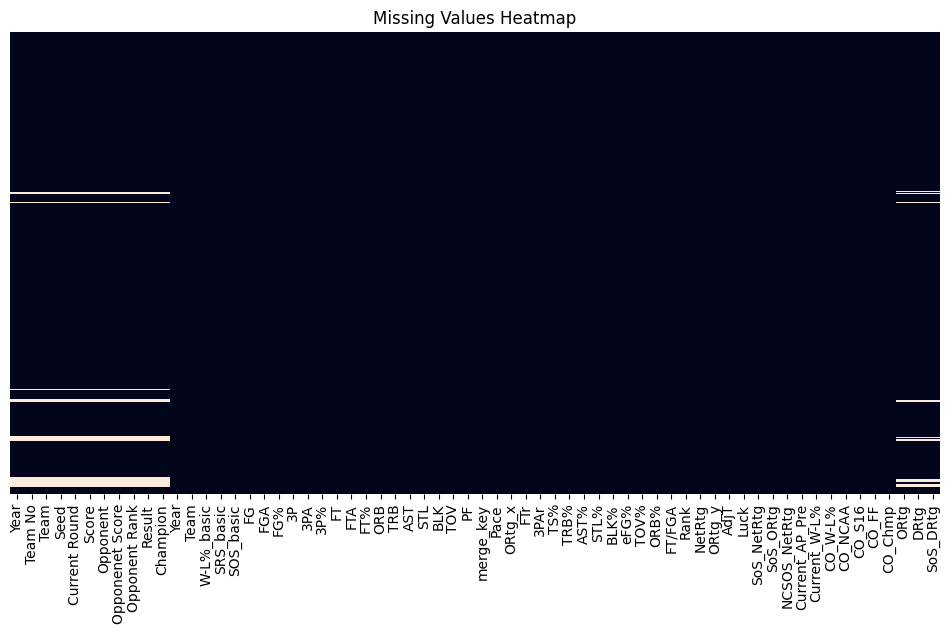

In [23]:
champion_predictor_df = pd.concat(champion_predictor_df, ignore_index=True)
print(champion_predictor_df.head(30))
print()
print()
print('COLUMNS')
print(champion_predictor_df.columns)
print()
print()
print('SHAPE')
print(champion_predictor_df.shape)
print()
print()
print('INFO')
print(champion_predictor_df.info())
print()
print()
print('DESCRIBE')
print(champion_predictor_df.describe())
print()
print()
print('SUM NA')
print(champion_predictor_df.isna().sum().sort_values(ascending=False))
print()
print()
print('SUM DUPLICATED')
print(champion_predictor_df.duplicated().sum())
print()
print()
print('COLUMNS WITH NA')
nan_cols = champion_predictor_df.columns[champion_predictor_df.isna().any()]
print("Columns with NaN:", list(nan_cols))
print()
plt.figure(figsize=(12, 6))
sns.heatmap(champion_predictor_df.isna(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [24]:
# Make sure both DataFrames are clean and aligned
#champion_predictor_df["Team"] = champion_predictor_df["Team"].astype(str).str.strip()
#champion_predictor_df["Year"] = pd.to_numeric(champion_predictor_df["Year"], errors="coerce").astype("Int64")

#final_combined_df["Team"] = final_combined_df["Team"].astype(str).str.strip()
#final_combined_df["Year"] = pd.to_numeric(final_combined_df["Year"], errors="coerce").astype("Int64")

# Optional: Drop non-essentials if merge_key isn't needed anymore
#final_combined_df = final_combined_df.drop(columns=["merge_key"], errors="ignore")

# Merge stats into the tournament frame
#enriched_df = pd.merge(champion_predictor_df, final_combined_df, on=["Year", "Team"], how="left")


In [25]:
print(champion_predictor_df.columns)
# Example: Replace all headers explicitly
champion_predictor_df.columns = [
    'Year', 'Team No', 'Team', 'Seed', 'Current Round', 'Score', 'Opponent', 'Opponenet Score', 'Result', 'Champion', 'merge_key', 'Year.1', 'Team.1',
       'W-L%_basic', 'SRS_basic', 'SOS_basic', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'merge_key.1', 'Pace', 'ORtg_x', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Rank', 'NetRtg', 'ORtg_y', 'AdjT', 'Luck', 'SoS_NetRtg', 'SoS_ORtg',
       'NCSOS_NetRtg', 'Current_AP_Pre', 'Current_W-L%', 'CO_W-L%', 'CO_NCAA', 'CO_S16', 'CO_FF', 'CO_Chmp', 'ORtg', 'DRtg', 'SoS_DRtg'
]

champion_predictor_df = champion_predictor_df.drop(columns=["merge_key", "Year.1", "Team.1", "merge_key.1"], errors="ignore")

champion_predictor_df.columns

output_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Variable Creation Sheet Work addresses\champion_predictor_df.csv"

champion_predictor_df.to_csv(output_path, index=False)

Index(['Year', 'Team No', 'Team', 'Seed', 'Current Round', 'Score', 'Opponent',
       'Opponenet Score', 'Opponent Rank', 'Result', 'Champion', 'Year',
       'Team', 'W-L%_basic', 'SRS_basic', 'SOS_basic', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'merge_key', 'Pace', 'ORtg_x', 'FTr', '3PAr', 'TS%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA',
       'Rank', 'NetRtg', 'ORtg_y', 'AdjT', 'Luck', 'SoS_NetRtg', 'SoS_ORtg',
       'NCSOS_NetRtg', 'Current_AP_Pre', 'Current_W-L%', 'CO_W-L%', 'CO_NCAA',
       'CO_S16', 'CO_FF', 'CO_Chmp', 'ORtg', 'DRtg', 'SoS_DRtg'],
      dtype='object')


OSError: Cannot save file into a non-existent directory: 'C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Variable Creation Sheet Work addresses'

In [26]:
# Create a probability of winning the championship
# Split data into training and test data sets
# Split data
# Define the feature subset you want to keep
selected_columns = [
    "Champion", "Year", "Seed", "Current Round", "W-L%_basic", "SRS_basic",
    "SOS_basic", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "FT", "FTA", "FT%",
    "ORB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "Pace", "ORtg_x", "FTr",
    "3PAr", "TS%", "TRB%", "AST%", "STL%", "BLK%", "eFG%", "TOV%", "ORB%",
    "FT/FGA", "Rank", "NetRtg", "ORtg_y", "AdjT", "Luck", "SoS_NetRtg",
    "SoS_ORtg", "NCSOS_NetRtg", "Current_AP_Pre", "Current_W-L%", "CO_W-L%",
    "CO_NCAA", "CO_S16", "CO_FF", "CO_Chmp", "ORtg", "DRtg", "SoS_DRtg"
]

# Apply column subset to training and testing splits
train_champion_predictor_df = champion_predictor_df[(champion_predictor_df["Year"] < 2025)][selected_columns]
test_champion_predictor_df = champion_predictor_df[(champion_predictor_df["Year"] == 2025)][selected_columns]

x_train_champion_predictor_df = train_champion_predictor_df.drop(columns=["Champion"])
y_train_champion_predictor_df = train_champion_predictor_df["Champion"]
x_test_champion_predictor_df = test_champion_predictor_df.drop(columns=["Champion"])
y_test_champion_predictor_df = test_champion_predictor_df["Champion"]

#Standardize X sets
#x_train_champion_predictor_df_scaled = preprocessing.StandardScaler().fit(x_train_champion_predictor_df).transform(x_train_champion_predictor_df)
#x_test_champion_predictor_df_scaled = preprocessing.StandardScaler().fit(x_test_champion_predictor_df).transform(x_test_champion_predictor_df)


# Convert back to DataFrame
#x_train_champion_predictor_df = pd.DataFrame(x_train_champion_predictor_df_scaled, columns=x_train_champion_predictor_df.columns, index=x_train_champion_predictor_df.index)
#x_test_champion_predictor_df = pd.DataFrame(x_test_champion_predictor_df_scaled, columns=x_test_champion_predictor_df.columns, index=x_test_champion_predictor_df.index)

#Look at standardized data
print(x_train_champion_predictor_df.head())
print(x_test_champion_predictor_df.head())

     Year  Seed  Current Round  W-L%_basic  SRS_basic  SOS_basic    FG   FGA  \
0  2012.0   9.0           64.0       0.636      13.76       7.18   778  1722   
1  2012.0   3.0           64.0       0.789      16.54       8.03  1004  2148   
2  2012.0   3.0           32.0       0.789      16.54       8.03  1004  2148   
3  2012.0   3.0           16.0       0.789      16.54       8.03  1004  2148   
4  2012.0   3.0            8.0       0.789      16.54       8.03  1004  2148   

     FG%   3P  ...  Current_AP_Pre  Current_W-L%  CO_W-L%  CO_NCAA  CO_S16  \
0  0.452  136  ...            19.0         0.636    0.685      3.0     0.0   
1  0.467  259  ...            12.0         0.789    0.567      3.0     2.0   
2  0.467  259  ...            12.0         0.789    0.567      3.0     2.0   
3  0.467  259  ...            12.0         0.789    0.567      3.0     2.0   
4  0.467  259  ...            12.0         0.789    0.567      3.0     2.0   

   CO_FF  CO_Chmp  ORtg  DRtg  SoS_DRtg  
0    0.0

In [27]:
# Check before dropping
print("🔍 NaNs in training set:", x_train_champion_predictor_df.isna().sum().sum())
print("🔍 NaNs in test set:", x_test_champion_predictor_df.isna().sum().sum())

# Drop rows with any NaNs
x_train_champion_predictor_df = x_train_champion_predictor_df.dropna()
x_test_champion_predictor_df = x_test_champion_predictor_df.dropna()

# If you also want to keep y aligned:
y_train_champion_predictor_df = y_train_champion_predictor_df.loc[x_train_champion_predictor_df.index]
y_test_champion_predictor_df = y_test_champion_predictor_df.loc[x_test_champion_predictor_df.index]

# Confirm cleaned shapes
print(" Training shape after drop:", x_train_champion_predictor_df.shape)
print(" Test shape after drop:", x_test_champion_predictor_df.shape)

🔍 NaNs in training set: 12
🔍 NaNs in test set: 0
✅ Training shape after drop: (1188, 53)
✅ Test shape after drop: (116, 53)


# Logistic Regression

In [28]:
LogReg = LogisticRegression(max_iter = 250)
LogReg.fit(x_train_champion_predictor_df, y_train_champion_predictor_df)
log_probs = LogReg.predict_proba(x_test_champion_predictor_df)[:, 1] # Probability of winning the championship

C:\Users\coltm\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 250 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=250).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest Classifier

In [29]:
rf_model = RandomForestClassifier(  n_estimators=250, max_depth=3, min_samples_split=4, min_samples_leaf=3,
    max_features='sqrt', class_weight='balanced', random_state=42)
rf_model.fit(x_train_champion_predictor_df, y_train_champion_predictor_df)
rf_probs = rf_model.predict_proba(x_test_champion_predictor_df)[:, 1] # Probability of winning the championship

# Gradient Boosting Classifier

In [30]:
gb_model = GradientBoostingClassifier(n_estimators=250, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(x_train_champion_predictor_df, y_train_champion_predictor_df)
gb_probs = gb_model.predict_proba(x_test_champion_predictor_df)[:, 1] # Probability of winning the championship

# GPU Powered XGBoost

In [31]:
param_grid = {"learning_rate": [0.1], "max_depth": [5], "n_estimators": [250], "subsample": [.6], 
              "colsample_bytree": [.75]}
xgb_model = GridSearchCV(estimator=xgb.XGBClassifier(tree_method="hist", device="cuda"), param_grid=param_grid, cv=5, scoring="roc_auc")
xgb_model.fit(x_train_champion_predictor_df, y_train_champion_predictor_df)
xgb_probs = xgb_model.predict_proba(x_test_champion_predictor_df)[:, 1]


C:\Users\coltm\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:729: UserWarning: [13:48:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [32]:
# Create DataFrame with all the probabilities created
champion_predictor_probs = pd.DataFrame({"Logistic": log_probs, "RanFor": rf_probs, "GradBoost": gb_probs, "XGBoost": xgb_probs})
# Create two combined probabiliti that takes all of them and puts them together.  1) Mean of the 4 and 2) A weighted scale
champion_predictor_probs ["Prob Mean"] = champion_predictor_probs .mean(axis=1)
champion_predictor_probs ["Combined"] = (0.3 * champion_predictor_probs ["Logistic"] + 0.5 * champion_predictor_probs ["RanFor"] +
    0.025 * champion_predictor_probs ["GradBoost"] + 0.175 * champion_predictor_probs ["XGBoost"])

print(champion_predictor_probs)

     Logistic    RanFor  GradBoost   XGBoost  Prob Mean  Combined
0    0.140982  0.302578   0.759945  0.400511   0.401004  0.282672
1    0.990007  0.769513   0.999626  0.999503   0.939662  0.881662
2    0.942587  0.758483   0.994903  0.998056   0.923507  0.861550
3    0.869848  0.723792   0.667766  0.979792   0.810299  0.811008
4    0.810037  0.722571   0.337275  0.824192   0.673519  0.756962
..        ...       ...        ...       ...        ...       ...
111  0.035785  0.203914   0.004066  0.008281   0.063011  0.114243
112  0.118510  0.157280   0.005049  0.025318   0.076539  0.118750
113  0.055934  0.133962   0.001657  0.003436   0.048747  0.084404
114  0.950855  0.599134   0.986099  0.983271   0.879840  0.781549
115  0.939227  0.599134   0.986099  0.983271   0.876933  0.778060

[116 rows x 6 columns]


In [33]:
champion_predictor_probs_2025 = champion_predictor_probs

# Evaluate the four metrics
    Accuracy Score
    ROC AUC Score
    Log Loss Score

In [34]:
def evaluate_model(probs, name):
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y_test_champion_predictor_df, preds)
    auc = roc_auc_score(y_test_champion_predictor_df, probs)
    loss = log_loss(y_test_champion_predictor_df, probs)
    return {
        "Model": name,
        "Accuracy": acc,
        "ROC-AUC": auc,
        "LogLoss": loss
    }

results = [
    evaluate_model(log_probs, "Logistic"),
    evaluate_model(rf_probs, "Random Forest"),
    evaluate_model(gb_probs, "Gradient Boosting"),
    evaluate_model(xgb_probs, "XGBoost"),
    evaluate_model(champion_predictor_probs["Prob Mean"], "Prob Mean"),
    evaluate_model(champion_predictor_probs["Combined"], "Combined")    
]

results_df = pd.DataFrame(results)
print(results_df.sort_values("ROC-AUC", ascending=False))


               Model  Accuracy   ROC-AUC   LogLoss
4          Prob Mean  0.801724  0.905357  0.446275
3            XGBoost  0.784483  0.901042  0.493487
5           Combined  0.741379  0.891667  0.486344
0           Logistic  0.715517  0.878571  0.534852
2  Gradient Boosting  0.801724  0.876935  0.541172
1      Random Forest  0.706897  0.822917  0.549578


In [35]:
scores = cross_val_score(gb_model, x_train_champion_predictor_df, y_train_champion_predictor_df, cv=5, scoring='roc_auc')
print("CV ROC-AUC (Gradient Boosting):", scores.mean())

CV ROC-AUC (Gradient Boosting): 0.8189552005284841


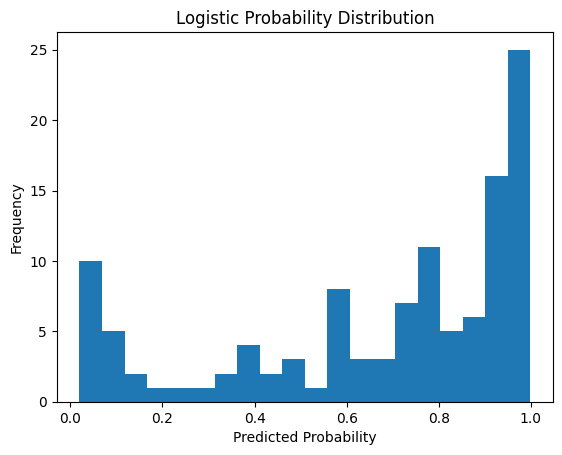

In [36]:
plt.hist(log_probs, bins=20)
plt.title("Logistic Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

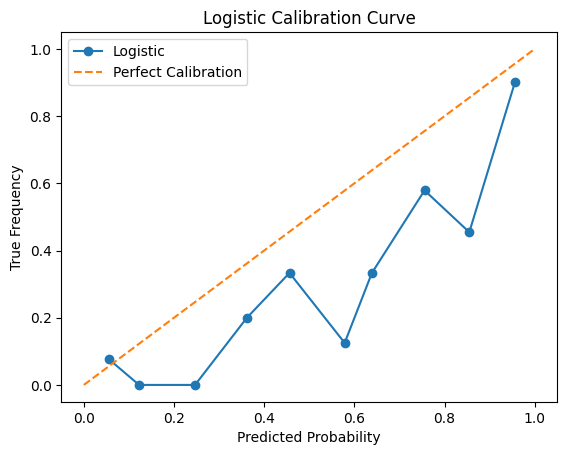

In [37]:
prob_true, prob_pred = calibration_curve(
    y_test_champion_predictor_df, log_probs, n_bins=10
)

plt.plot(prob_pred, prob_true, marker='o', label='Logistic')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.legend()
plt.title("Logistic Calibration Curve")
plt.show()

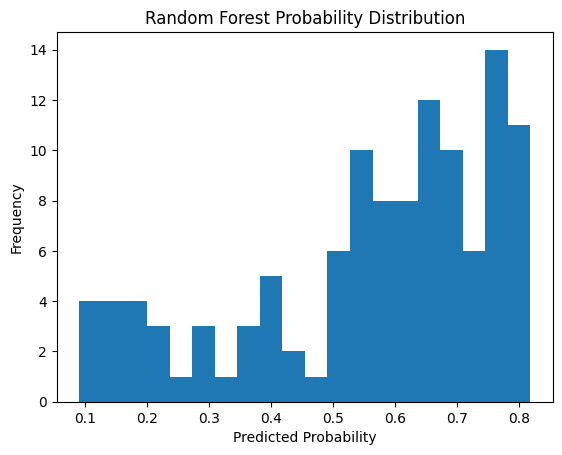

In [38]:
plt.hist(rf_probs, bins=20)
plt.title("Random Forest Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

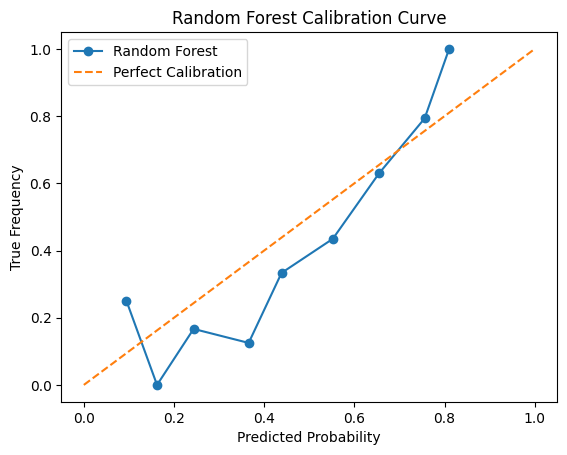

In [39]:
prob_true, prob_pred = calibration_curve(
    y_test_champion_predictor_df, rf_probs, n_bins=10
)

plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.legend()
plt.title("Random Forest Calibration Curve")
plt.show()

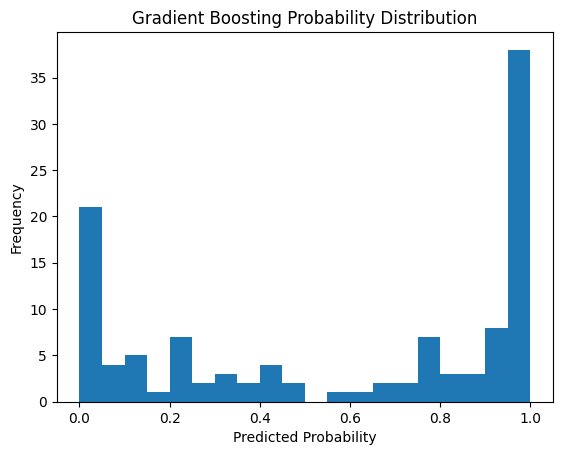

In [40]:
plt.hist(gb_probs, bins=20)
plt.title("Gradient Boosting Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

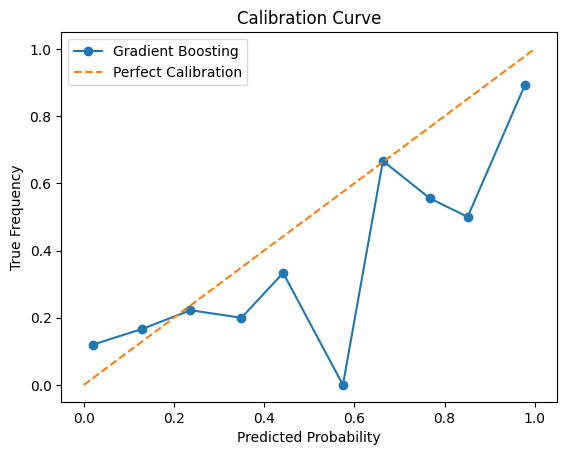

In [41]:
prob_true, prob_pred = calibration_curve(
    y_test_champion_predictor_df, gb_probs, n_bins=10
)

plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.legend()
plt.title("Calibration Curve")
plt.show()

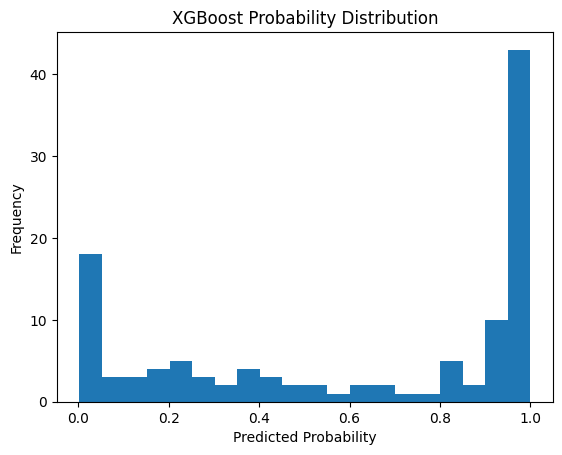

In [42]:
plt.hist(xgb_probs, bins=20)
plt.title("XGBoost Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

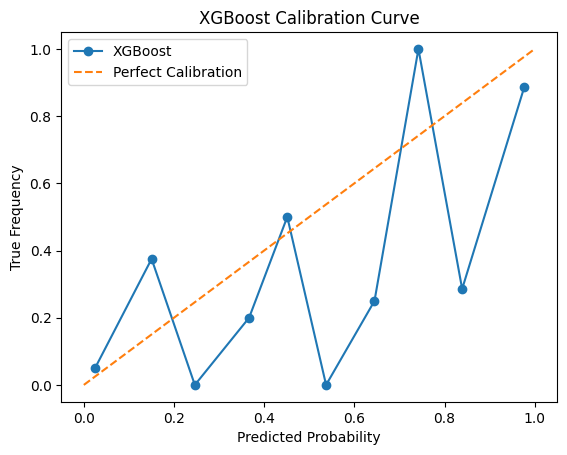

In [43]:
prob_true, prob_pred = calibration_curve(
    y_test_champion_predictor_df, xgb_probs, n_bins=10
)

plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.legend()
plt.title("XGBoost Calibration Curve")
plt.show()

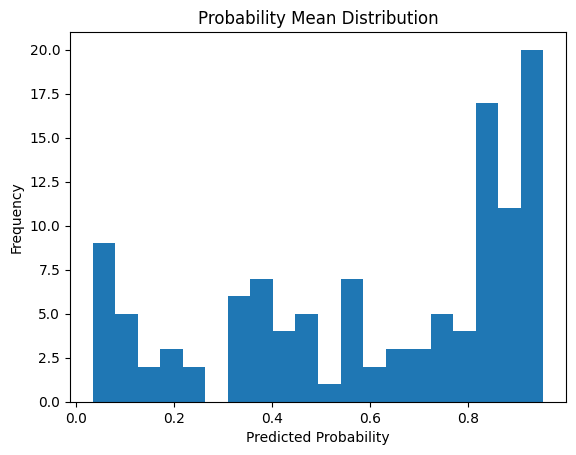

In [44]:
plt.hist(champion_predictor_probs["Prob Mean"], bins=20)
plt.title("Probability Mean Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

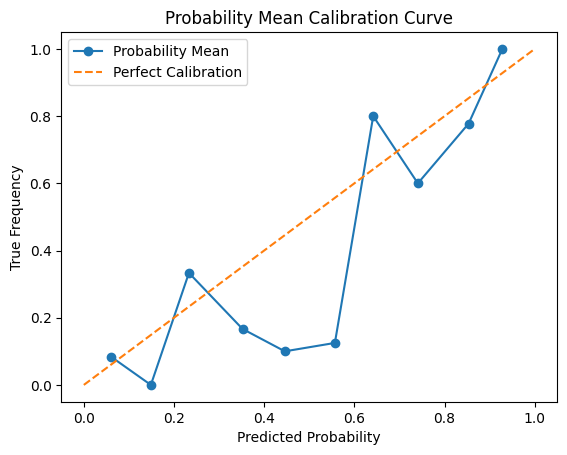

In [45]:
prob_true, prob_pred = calibration_curve(
    y_test_champion_predictor_df, champion_predictor_probs["Prob Mean"], n_bins=10
)

plt.plot(prob_pred, prob_true, marker='o', label='Probability Mean')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.legend()
plt.title("Probability Mean Calibration Curve")
plt.show()

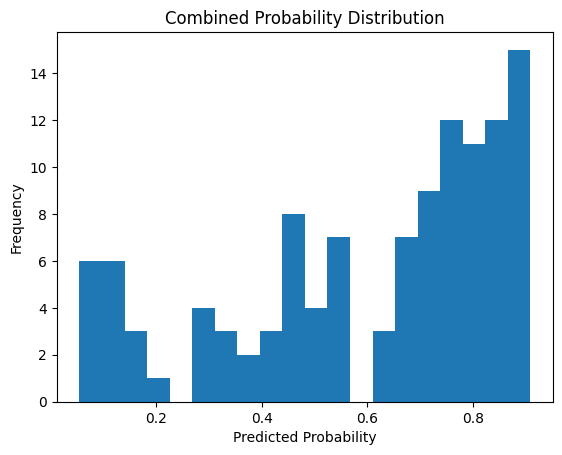

In [46]:
plt.hist(champion_predictor_probs["Combined"], bins=20)
plt.title("Combined Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

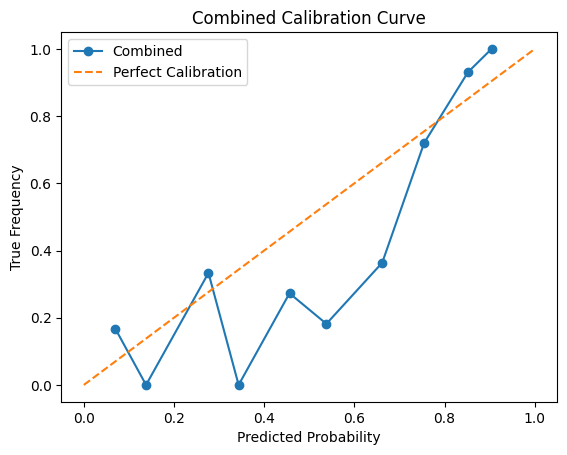

In [47]:
prob_true, prob_pred = calibration_curve(
    y_test_champion_predictor_df, champion_predictor_probs["Combined"], n_bins=10
)

plt.plot(prob_pred, prob_true, marker='o', label='Combined')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.legend()
plt.title("Combined Calibration Curve")
plt.show()

Descision:  Going to use the Random Forest and Combined Probablity as for the model.  Its distribution looks better and I am worried about overfitting based on how perfect the fits seem to be. 

# Create probs for the rest of the data so it can be used for later models

In [48]:
log_probs_train = LogReg.predict_proba(x_train_champion_predictor_df,)[:, 1] 

In [49]:
rf_probs_train = rf_model.predict_proba(x_train_champion_predictor_df,)[:, 1] 

In [50]:
gb_probs_train = gb_model.predict_proba(x_train_champion_predictor_df,)[:, 1] 

In [51]:
xgb_probs_train = xgb_model.predict_proba(x_train_champion_predictor_df,)[:, 1]

In [52]:
# Create DataFrame with all the probabilities created
champion_predictor_probs_train = pd.DataFrame({"Logistic": log_probs_train, "RanFor": rf_probs_train, "GradBoost": gb_probs_train,
                                               "XGBoost": xgb_probs_train})
# Create two combined probabiliti that takes all of them and puts them together.  1) Mean of the 4 and 2) A weighted scale
champion_predictor_probs_train  ["Prob Mean"] = champion_predictor_probs_train .mean(axis=1)
champion_predictor_probs_train  ["Combined"] = (0.2 * champion_predictor_probs_train  ["Logistic"] + 0.25 * champion_predictor_probs_train  ["RanFor"] +
    0.25 * champion_predictor_probs_train  ["GradBoost"] + 0.3 * champion_predictor_probs_train  ["XGBoost"])

print(champion_predictor_probs_train)

      Logistic    RanFor  GradBoost   XGBoost  Prob Mean  Combined
0     0.541963  0.337332   0.013579  0.080806   0.243420  0.220362
1     0.935038  0.680944   0.999865  0.999862   0.903927  0.907168
2     0.704602  0.658790   0.999317  0.997787   0.840124  0.854783
3     0.492643  0.629523   0.976308  0.915294   0.753442  0.774575
4     0.382536  0.629523   0.028413  0.101879   0.285588  0.271555
...        ...       ...        ...       ...        ...       ...
1183  0.482429  0.298364   0.968908  0.872005   0.655427  0.674905
1184  0.133797  0.289628   0.003081  0.025079   0.112896  0.107460
1185  0.974987  0.742026   0.995573  0.992438   0.926256  0.927129
1186  0.865942  0.730891   0.981826  0.930752   0.877353  0.880593
1187  0.724482  0.692755   0.040222  0.107489   0.391237  0.360388

[1188 rows x 6 columns]


Add RanFor and Combined to the test and train features

In [53]:
x_train_champion_predictor_df["RanFor"] =  champion_predictor_probs_train["RanFor"]
x_train_champion_predictor_df["Combined"] =  champion_predictor_probs_train["Combined"]

In [54]:
x_train_champion_predictor_df

,Year,Seed,Current Round,W-L%_basic,SRS_basic,SOS_basic,FG,FGA,FG%,3P,...,CO_W-L%,CO_NCAA,CO_S16,CO_FF,CO_Chmp,ORtg,DRtg,SoS_DRtg,RanFor,Combined
0,2012.0,9.0,64.0,0.636,13.76,7.18,778,1722,0.452,136,...,0.685,3.0,0.0,0.0,0.0,91.8,89.5,100.3,0.337332,0.220362
1,2012.0,3.0,64.0,0.789,16.54,8.03,1004,2148,0.467,259,...,0.567,3.0,2.0,0.0,0.0,97.1,94.7,98.5,0.680944,0.907168
2,2012.0,3.0,32.0,0.789,16.54,8.03,1004,2148,0.467,259,...,0.567,3.0,2.0,0.0,0.0,97.1,94.7,98.5,0.658790,0.854783
3,2012.0,3.0,16.0,0.789,16.54,8.03,1004,2148,0.467,259,...,0.567,3.0,2.0,0.0,0.0,97.1,94.7,98.5,0.629523,0.774575
4,2012.0,3.0,8.0,0.789,16.54,8.03,1004,2148,0.467,259,...,0.567,3.0,2.0,0.0,0.0,97.1,94.7,98.5,0.629523,0.271555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,2024.0,12.0,64.0,0.857,10.45,-0.52,924,2008,0.460,245,...,0.648,6.0,0.0,0.0,0.0,95.6,98.1,105.1,NaN,NaN
1221,2024.0,12.0,32.0,0.857,10.45,-0.52,924,2008,0.460,245,...,0.648,6.0,0.0,0.0,0.0,95.6,98.1,105.1,NaN,NaN
1222,2024.0,1.0,64.0,0.784,21.36,9.90,1046,2323,0.450,301,...,0.716,2.0,2.0,1.0,0.0,98.6,93.5,100.5,NaN,NaN
1223,2024.0,1.0,32.0,0.784,21.36,9.90,1046,2323,0.450,301,...,0.716,2.0,2.0,1.0,0.0,98.6,93.5,100.5,NaN,NaN
